In [94]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [95]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [96]:
# Load the dataset
def load_and_preprocess(file_path):
    # Read the CSV file
    data = pd.read_csv(file_path)
    
    # Convert 'Date' column to datetime and set it as the index
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    
    # Sort the DataFrame by the 'Date' index in ascending order
    data.sort_index(inplace=True)
    
    # Clean the 'Price' column
    data['Price'] = data['Price'].astype(str).str.replace(',', '').astype(float)
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(subset=['Price'], inplace=True)
    
    return data

In [97]:
# Load and preprocess Intel and AMD datasets
intel_data = load_and_preprocess('../../Dataset/intel_stock_price.csv')

In [98]:
intel_data

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2020-12-31,49.82,48.75,50.19,48.72,28.58M,2.19%
2021-01-04,49.67,49.89,51.39,49.40,46.10M,-0.30%
2021-01-05,50.61,49.45,50.83,49.33,24.87M,1.89%
2021-01-06,51.10,50.44,52.15,50.20,36.81M,0.97%
2021-01-07,52.19,51.49,52.69,51.30,32.09M,2.13%
...,...,...,...,...,...,...
2025-04-09,21.53,18.07,21.73,17.98,224.18M,18.75%
2025-04-10,19.88,20.67,20.82,19.16,129.06M,-7.66%
2025-04-11,19.74,19.25,19.80,18.17,128.43M,-0.70%


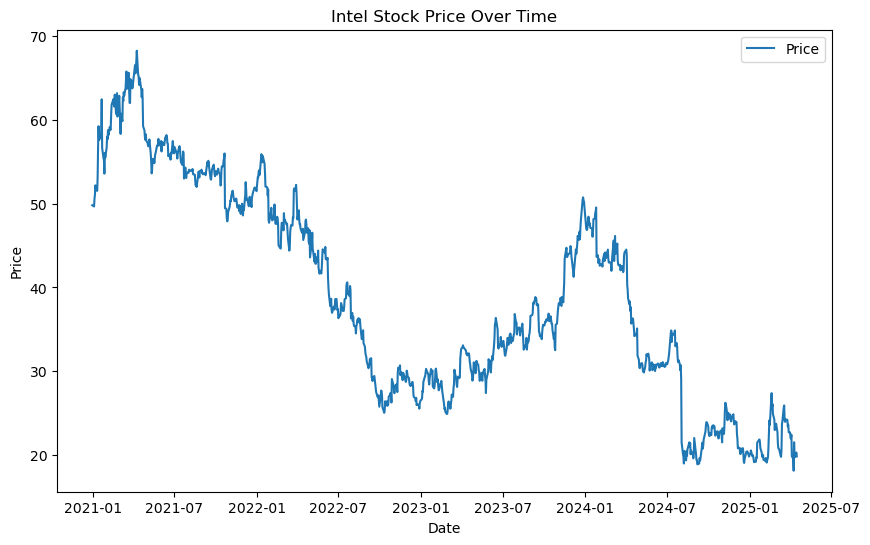

In [99]:
# Plot the 'Price' column over time
def plot_price(data, title):
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data['Price'], label='Price')
    plt.title(f'{title} Stock Price Over Time')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

plot_price(intel_data, 'Intel')

In [100]:

# Perform stationarity test using Augmented Dickey-Fuller (ADF) test
def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna())
    labels = ['ADF Test Statistic', 'p-value', '# Lags Used', '# Observations']
    out = pd.Series(result[0:4], index=labels)
    for key, val in result[4].items():
        out[f'Critical Value ({key})'] = val
    print(out.to_string())
    if result[1] <= 0.05:
        print("Data is stationary.")
    else:
        print("Data is not stationary.")


In [101]:
print("Intel Stock Price Stationarity Test:")
adf_test(intel_data['Price'], 'Intel Stock Price')



Intel Stock Price Stationarity Test:
Augmented Dickey-Fuller Test: Intel Stock Price
ADF Test Statistic        -1.009894
p-value                    0.749639
# Lags Used                0.000000
# Observations          1076.000000
Critical Value (1%)       -3.436442
Critical Value (5%)       -2.864230
Critical Value (10%)      -2.568202
Data is not stationary.


In [102]:

# Perform differencing if data is not stationary
def make_stationary(data, column):
    data[f'Log_{column}'] = np.log(data[column])
    data[f'Log_Diff_{column}'] = data[f'Log_{column}'].diff()
    return data

In [103]:
intel_data = make_stationary(intel_data, 'Price')


In [122]:

# Re-test stationarity after differencing
print("\nIntel Stock Price Stationarity Test After Differencing:")
adf_test(intel_data['Log_Diff_Price'], 'Intel Stock Price After Differencing')


Intel Stock Price Stationarity Test After Differencing:
Augmented Dickey-Fuller Test: Intel Stock Price After Differencing
ADF Test Statistic       -21.678591
p-value                    0.000000
# Lags Used                1.000000
# Observations          1074.000000
Critical Value (1%)       -3.436453
Critical Value (5%)       -2.864235
Critical Value (10%)      -2.568205
Data is stationary.


In [123]:

# Plot the differenced data
def plot_differenced(data, column, title):
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data[column], label='Differenced Price')
    plt.title(f'{title} Differenced Stock Price')
    plt.xlabel('Date')
    plt.ylabel('Differenced Price')
    plt.legend()
    plt.show()


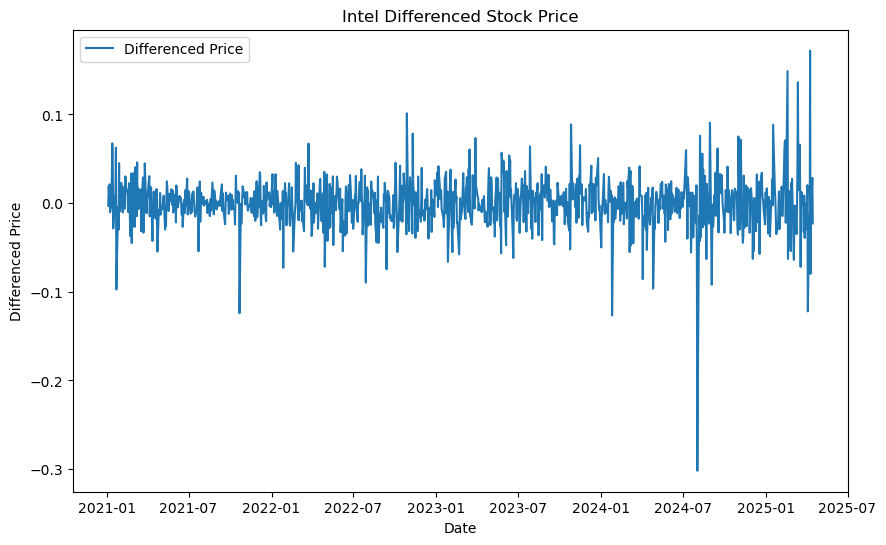

In [124]:

plot_differenced(intel_data, 'Log_Diff_Price', 'Intel')

In [125]:
# Convert to Stationary Time Series
intel_data['Log_Price'] = np.log(intel_data['Price'])
intel_data['Log_Diff'] = intel_data['Log_Price'].diff().dropna()


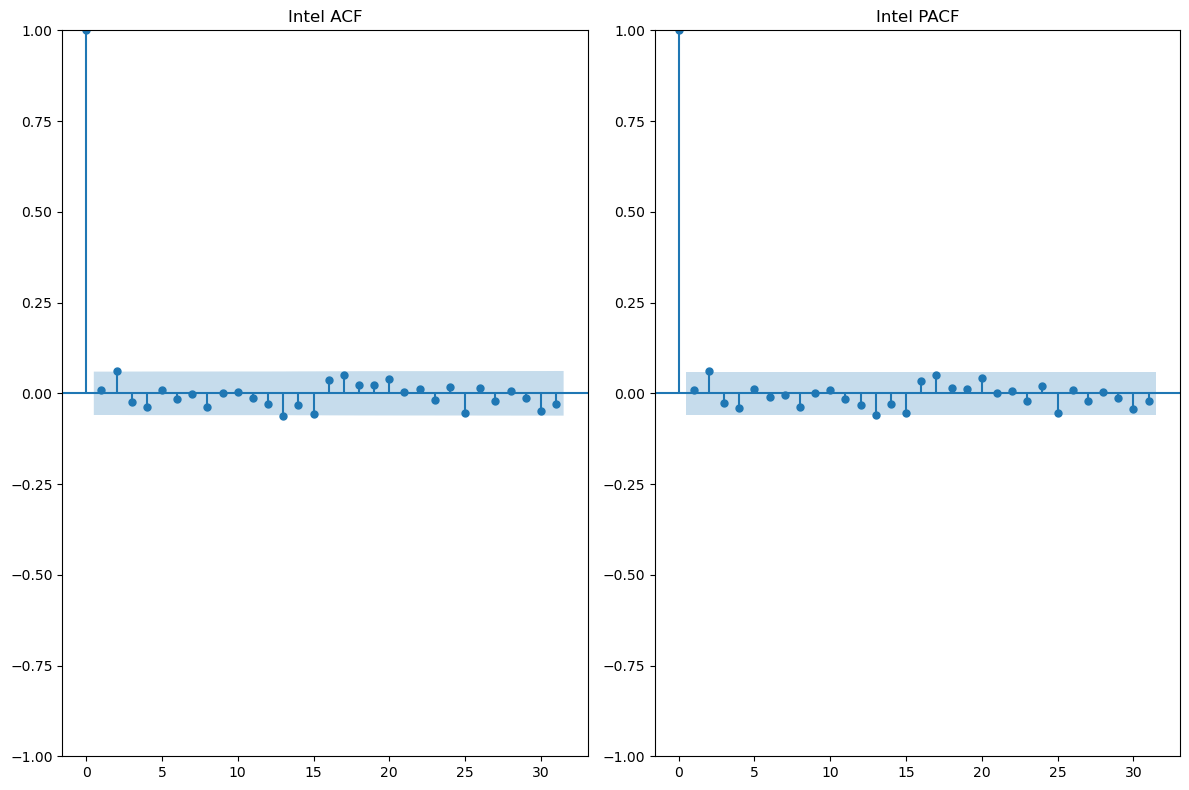

In [137]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
plot_acf(intel_data['Log_Diff'].dropna(), ax=axes[0], title="Intel ACF")
plot_pacf(intel_data['Log_Diff'].dropna(), ax=axes[1], title="Intel PACF")
plt.tight_layout()
plt.show()

In [138]:
# Train-Test Split
def train_test_split(data, split_ratio=0.9):
    train_size = int(len(data) * split_ratio)
    train = data[:train_size]
    test = data[train_size:]
    return train, test

In [139]:
intel_train, intel_test = train_test_split(intel_data['Log_Price'])

In [140]:
from pmdarima import auto_arima

In [141]:
# Sử dụng auto_arima để tìm tham số tốt nhất
print("Finding the best ARIMA parameters using auto_arima...")
auto_arima_model = auto_arima(intel_train, 
                              start_p=1, start_q=1,
                              max_p=5, max_q=5,
                              seasonal=False, 
                              trace=True, 
                              error_action='ignore', 
                              suppress_warnings=True, 
                              stepwise=True)


Finding the best ARIMA parameters using auto_arima...
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4307.331, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4310.451, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4309.213, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4309.180, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4311.732, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.666 seconds


In [142]:
# In tham số tốt nhất
print(f"Best ARIMA order: {auto_arima_model.order}")

Best ARIMA order: (0, 1, 0)


In [143]:
# Huấn luyện mô hình ARIMA với tham số từ auto_arima
def fit_arima_and_forecast(train, test, order):
    # Huấn luyện mô hình ARIMA
    model = ARIMA(train, order=order)
    model_fit = model.fit()
    
    # Dự báo trên tập Test
    forecast = model_fit.forecast(steps=len(test))
    
    # Đánh giá mô hình
    aic = model_fit.aic
    bic = model_fit.bic
    rmse = np.sqrt(mean_squared_error(test, forecast))
    
    print(f"AIC: {aic}")
    print(f"BIC: {bic}")
    print(f"RMSE: {rmse}")
    
    return model_fit, forecast

In [144]:

# Huấn luyện và dự báo cho Intel
print("\nIntel ARIMA Model:")
intel_model, intel_forecast = fit_arima_and_forecast(intel_train, intel_test, order=auto_arima_model.order)



Intel ARIMA Model:
AIC: -4311.731933090599
BIC: -4306.856701003323
RMSE: 0.17041832064721624


In [145]:
# Plot actual vs forecasted values
def plot_forecast(train, test, forecast, title):
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train, label='Train Data')
    plt.plot(test.index, test, label='Test Data', color='orange')
    plt.plot(test.index, forecast, label='Forecast', color='green')
    plt.title(f'{title} - Actual vs Forecast')
    plt.xlabel('Date')
    plt.ylabel('Log Price')
    plt.legend()
    plt.show()

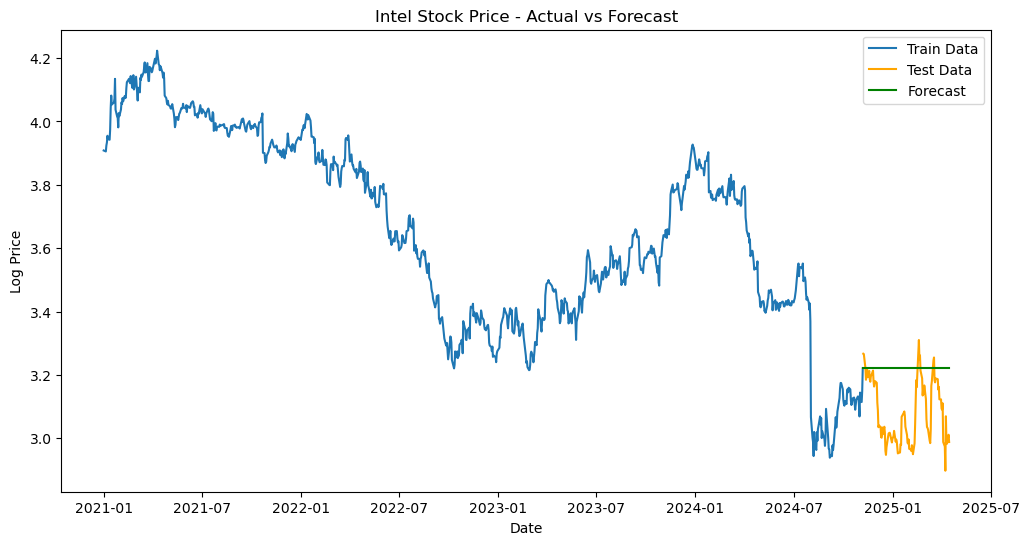

In [146]:

# Plot the forecast for Intel
plot_forecast(intel_train, intel_test, intel_forecast, 'Intel Stock Price')

SARIMA AIC: -4203.68407251764
SARIMA BIC: -4169.64476712628
SARIMA RMSE: 0.1247712018337438


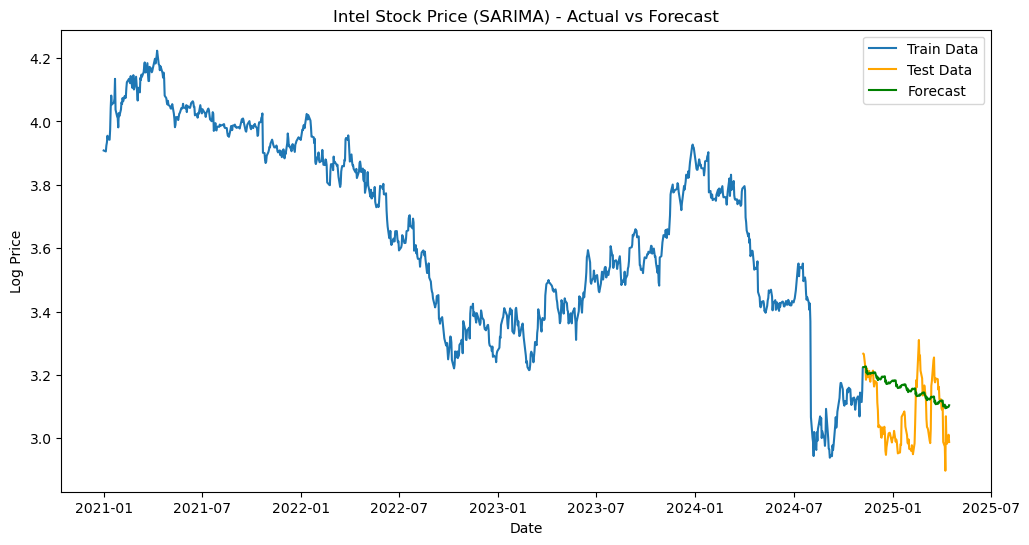

In [147]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Huấn luyện mô hình SARIMA
sarima_model = SARIMAX(intel_train, order=(2, 1, 2), seasonal_order=(1, 1, 1, 12))
sarima_model_fit = sarima_model.fit()

# Dự báo
sarima_forecast = sarima_model_fit.forecast(steps=len(intel_test))

# Đánh giá mô hình
print(f"SARIMA AIC: {sarima_model_fit.aic}")
print(f"SARIMA BIC: {sarima_model_fit.bic}")
print(f"SARIMA RMSE: {np.sqrt(mean_squared_error(intel_test, sarima_forecast))}")

# Vẽ biểu đồ
plot_forecast(intel_train, intel_test, sarima_forecast, 'Intel Stock Price (SARIMA)')